In [1]:
# makemore part 3 is more about efficiencies in the way the neural network behaves
# during training. The idea is to take the previous makemore and add some new layers
# and parameters to conditions the training so that it runs smoothly.

# Let us rewrite makemore first and make it a bit more mature

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Load data
words = open('names.txt','r').read().splitlines()
# Tokenize the input
chars = sorted(list(set(''.join(words))))# Make the items and chars to pull out a non repeating vocabulary of characters from the dataset.
# make a numeric identifier for each unique character
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0 # add an identifier which you can use to denote the beginning and end of each character (in the original paper, this is word)
# reverse the order
i2s = {i:s for s,i in s2i.items()} # this switches the key of the dictionary, making numerals identify a character, which is needed for languages.



In [2]:
size_network=200
batchnorm = True
lossi = []
lossi_te = []
batch_size = 64 # number of instances in each batch
block_size = 3 # number of input blocks. Will be equal to the total characters fed into the network to predict the next character.
characters_input = 32 # number of characters fed into the network
internal_embedding_size= 10 # number of internal number of outputs you want to compress the input into
characters_total = 27 # total number of characters or tokens that represent unique elements of the input database. Here it is 27 because we have 26 letters and a period .


# Step 1) Build the dataset
def build_dataset(words, block_size):
    #block_size = 3 # number of inputs going into the network, i.e., number of characters.
    X, Y = [],[] # X is the inputs (block_size in number), while Y is the output, which is one for this example.

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(i2s[i] for i in context), '---->', i2s[ix])
            #print(context[1:] + [ix])
            context = context[1:] + [ix]

    # convert to torch datasets
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

# Split dataset into training set and test set
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1],block_size) # training set is 0.8*len words
Xdev, Ydev = build_dataset(words[n1:n2],block_size) # dev set is between 0.8*len words and 0.9*len words
#Xte, Yte = build_dataset(words[n2:]) # test set is 0.9*len words to the end
Xte, Yte = build_dataset(words[n1:],block_size) # test set is 0.8*len words to the end

# The above plot shows a nice comfortable minimum for our learning rate at around 0.1
import numpy as np
# Let us now introduce the above model estimation using mini batches which speeds up iterations

# Step 2) Build the model
def model(batchnorm=batchnorm,modelsize=size_network,blocksize = block_size,charinsize=characters_input,internalembeddingsize= internal_embedding_size,totalchars=characters_total):
    
    g = torch.Generator().manual_seed(0)
    C = torch.randn((characters_total,internalembeddingsize),generator=g) # embedding matrix. Will act like one hot encoding for input characters of size 'charinsize=6'
    W1 = torch.randn((blocksize*internalembeddingsize,modelsize),generator=g) * (5/3)/((internalembeddingsize * block_size)**0.5) #* 0.2# weights from input 'charinsize=6' embedded inputs to hidden layer of output size 'size_network=1000'
    # As per kaiming normalization, before the tanh function, if you multiply the matrix with a gain of (5/3)/sqrt(inputmatrixsize), you get a variance of 1.
    # In torch.nn.Linear, the matrix is not normalized by (5/3))/sqrt(size_in), it does 1/sqrt(size_in).
    # This is because they sample from a uniform distribution between -1 and 1 and not random like ours. 

    if batchnorm == True:
        # add batch norm parameters
        bngain= torch.ones((1,modelsize))
        bnbias = torch.zeros((1,modelsize))
        bnmean_running= torch.zeros((1,modelsize))
        bnstd_running = torch.ones((1,modelsize))
    else:
        b1 = torch.randn(modelsize,generator=g) * 0.01# bias for hidden layer
    
    W2 = torch.randn(modelsize,totalchars,generator=g) * 0.001# weights from hidden layer to output layer
    b2 = torch.randn(totalchars,generator=g) * 0.001# bias for output layer
    
    if batchnorm == True:
        parameters = [C,W1,W2,b2, bngain, bnbias] # list of parameters to be updated
    else:
        parameters = [C,W1,b1,W2,b2] # list of parameters to be updated
    
    if batchnorm == True:
        return parameters, W1, W2, b2, C, bngain,bnbias,bnmean_running, bnstd_running
    else:
        return parameters, W1, b1, W2, b2, C

# Call model (not callable yet)
if batchnorm == True:
    parameters, W1, W2, b2, C, bngain,bnbias,bnmean_running, bnstd_running= model()
else:
    parameters, W1, b1, W2, b2, C = model()



print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


12097


In [64]:
# Step 3) Train the model
# update weights and biases including the input embedding matrix C
niters=1000

for i in range(niters):

    # mini batching
    ix = torch.randint(0,Xtr.shape[0],(batch_size,)) # returns 32 randomized instances if integers between 0 and the training set size
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    # Linear layer
    emb = C[Xb] # indexed inserted into inputs X
    embcat = emb.view(emb.shape[0], -1)
    if batchnorm == True:
        h = embcat @ W1 # + b1 # Can remove b1 if followed by a batchnorm layer as it is anyways going to take a mean and remove that mean, meaning if b multiplied by a mean is a mean around b, it will be removed in the batchnorm operation (see formula). Therefore, there is no point.
        # Batch normalization
        bnmeani = h.mean(0,keepdim=True)
        bnstdi = h.std(0,keepdim=True)
        hpreact = bngain * (h-bnmeani) / (bnstdi + 1e-8) + bnbias # use 1e-8 to prevent division by zero
        # This is a slight problem because the mean and standard deviation is now coupled with the batch currently being used to train
        # on, but not on the true mean and standard deviation of hpreact on the entire dataset.
        with torch.no_grad():
            bnmean_running = 0.999*bnmean_running + 0.001*bnmeani # update running mean
            bnstd_running = 0.999*bnstd_running + 0.001*bnstdi # update running std
        # Non-linearity
        h = torch.tanh(hpreact)
    else:
        hpnonbatchnorm = (embcat @ W1  + b1) # Can remove b1 if followed by a batchnorm layer as it is anyways going to take a mean and remove that mean, meaning if b multiplied by a mean is a mean around b, it will be removed in the batchnorm operation (see formula). Therefore, there is no point.
        h = torch.tanh(hpnonbatchnorm)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb) # indexes inserted into grount truths in Y

    
    # backward pass
    for p in parameters:
        p.grad = None # make gradients zero before each iteration
    loss.backward()

    # set learning rate decay schedule
    # the idea in the above is to start with a small number and iterate to converge faster towards the end
    if i< int(0.1*niters): # implement a small decay in the later stages to change our learning rate to something slower for better convergence as we see that with 0.1 it starts to plateau quickly
        lr = 0.1
    else:
        lr = 0.01

    lr = 0.1
    # calculate loss
    for p in parameters:
        #p.data += -0.01*p.grad # update parameters # -0.00001 is too low. -0.001 is good. -1 is too fast. -10 is unstable and all over the place
        p.data += -lr*p.grad # update paramerters based on iteration based learning rate


    
    # track stats
    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{niters:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    




      0/   1000: 2.4065
    100/   1000: 2.3012
    200/   1000: 2.2083
    300/   1000: 2.1525
    400/   1000: 2.3166
    500/   1000: 2.4632
    600/   1000: 2.4070
    700/   1000: 2.6378
    800/   1000: 2.5266
    900/   1000: 2.1212


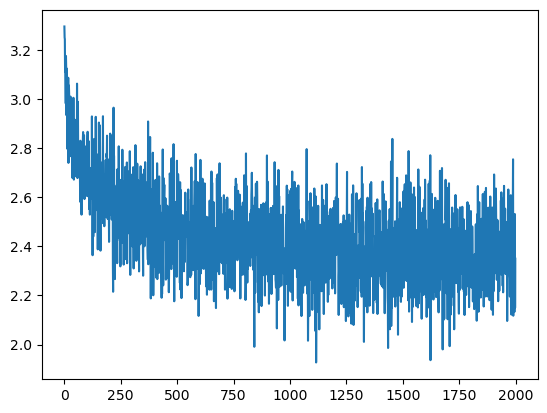

2.349522590637207


In [65]:
plt.plot(range(len(lossi)),lossi)   
plt.plot(range(len(lossi_te)),lossi_te)
plt.show()
print(loss.item())

In [72]:
# Caliberate the batchnorm at the end of the training by using the entire training set instead of the mini batch (explained in subsequently)
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


tensor(1.9947) tensor(2.5593) tensor(1.9538) tensor(2.5519)


In [73]:
# Calculate loss without any gradient tracking for efficiency purposes. Build a function that takes in a split of the 
# model input and output and outputs a training loss.

# This is a step after training to combat the effects of the gain and bias being trained based on mini batches of the training set.
# This requires taking the training set, getting the preactivations for all the examples in them, and then using the running
# mean and bias in the batchnorm layer. This is proposed by the authors of the batchnorm paper.

# This is done during raining under a torch.no_grad() header to prevent tracking its gradient.
# The running mean and bias is a linear combination of 90% of the running mean and 10% of the current batch's mean.

# with torch.no_grad():
 #   bnmean_running = 0.999*bnmean_running + 0.001*bnmeani # update running mean
 #   bnstd_running = 0.999*bnstd_running + 0.001*bnstdi # update running std

 # Use 0.999 and 0.001 as the model is small and not as complicated.  0.001 is the 'momentum'. 0.999 is the 'decay'.

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1 # bias removed when followed by batchnorm because it is anyways removed during mean removal in the batchnorm layer
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias 
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running+1e-8) + bnbias # 1e-8 is needed to prevent division by 0
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

print(bnmean.max(),bnstd.max(),bnmean_running.max(),bnstd_running.max()) 
# The above values are close. Therefore, you can either explicitly calculate the bnmean and bnstd for inference from the entire 
# training set (as above), or simply accumulate it during training using a suitable momentum and decay value.

train 2.3437843322753906
val 2.3483963012695312
tensor(1.9947) tensor(2.5593) tensor(1.9538) tensor(2.5519)


In [69]:
# Now let us try to generate some text using the above model
# Step 4) Generate text
g = torch.Generator().manual_seed(0)

for _ in range(20): # generate 20 samples
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # indexed inserted into inputs X
        #h = torch.tanh(emb.view(-1,block_size*internal_embedding_size) @ W1 + b1)
        h = torch.tanh(emb.view(-1,block_size*internal_embedding_size) @ W1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item() # sample from the distribution
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: # If we encounter a . in the prediction, then stop as this would mean it thinks that this would end the sequence
            break
    print(''.join(i2s[i] for i in out)) # join all predictions together and print


kedlelylennelyxtdembhvel.
lyler.
rippishfwajusr.
zialliernocez.
stjamarea.
macreckar.
rubher.
jonq.
shrisz.
ellzenqh.
dykaxtjom.
soh.
brus.
derchyl.
ajdxpzinammekusskyannloh.
dajjqhdily.
boun.
kresidfurrmingalhan.
cmadikonbe.
cezin.


In [81]:

# Example of initialization issue with softmax, which gives a high value of 27 in the beginning, wasting iterations
logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits,dim=0)
loss1 = -probs[1].log()
loss2 = -probs[3].log()
probs,loss1,loss2

# Gives a probability that is exactly uniform and the losses along all four dimensions of logits is the same 

# the loss is too high. You could add multiplications to logits to record a low loss
logits = torch.tensor([0.0,0.0,2.0,0.0])
probs = torch.softmax(logits,dim=0)
loss1 = -probs[1].log()
loss2 = -probs[2].log()
probs,loss1,loss2
# now you get lower loss because, by chance, you are assigning a 2.0 probability. 

logits = torch.tensor([0.0,0.0,5.0,0.0])
probs = torch.softmax(logits,dim=0)
loss1 = -probs[1].log()
loss2 = -probs[2].log()
probs,loss1,loss2
# now you get an even lower loss because, by chance, you are assigning a 2.0 probability. 

(tensor([0.0963, 0.0963, 0.7112, 0.0963]), tensor(2.3408), tensor(0.3408))

In [ ]:
# This mistake is therefore present in part_2 makemore because of the softmax exaggeration. 
# In the first iteration, prior to gradient update, the logits matrix has unrealistic and large values.
# As logits is an operation involving b2, W2 and h, the loss is high, the issues are in that layer.
# Therefore, after you initialize the parameters, postmultiplly the randomly generated b2 and W2 matrix by 0.001.

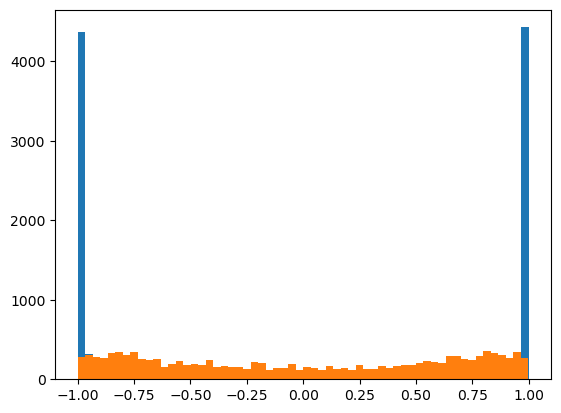

In [66]:
# Using that premultiplication, the first loss lowers to 3.29. The second issue now is the h matrix. 
plt.hist(torch.tanh(hpnonbatchnorm).view(-1).tolist(),60);
plt.hist(torch.tanh(hpreact.view(-1)).tolist(),60);
plt.show() # the h matrix was originally very condensed in the tail ends.

# What you see below is that the tanh, or the activation function, takes a broad tailed distribution and yields a saturation
# of values towards the extremes, and this does not happen for the batchnormed version of the h to which a tanh activation is applied.
# Therefore, one must try to normalize the results of each layer to have a mean of 0 and a standard deviation of 1. This will, as 
# best as possible, try to keep the tanh activation function from saturating. 

# This normally only happens in activation functions like tanh and relu, where there are regions of flatness, i.e.,
# for relu it will saturate below 0 because the gradient is flat. For tanh, it will saturate at -1 and 1 because the gradient is flat.



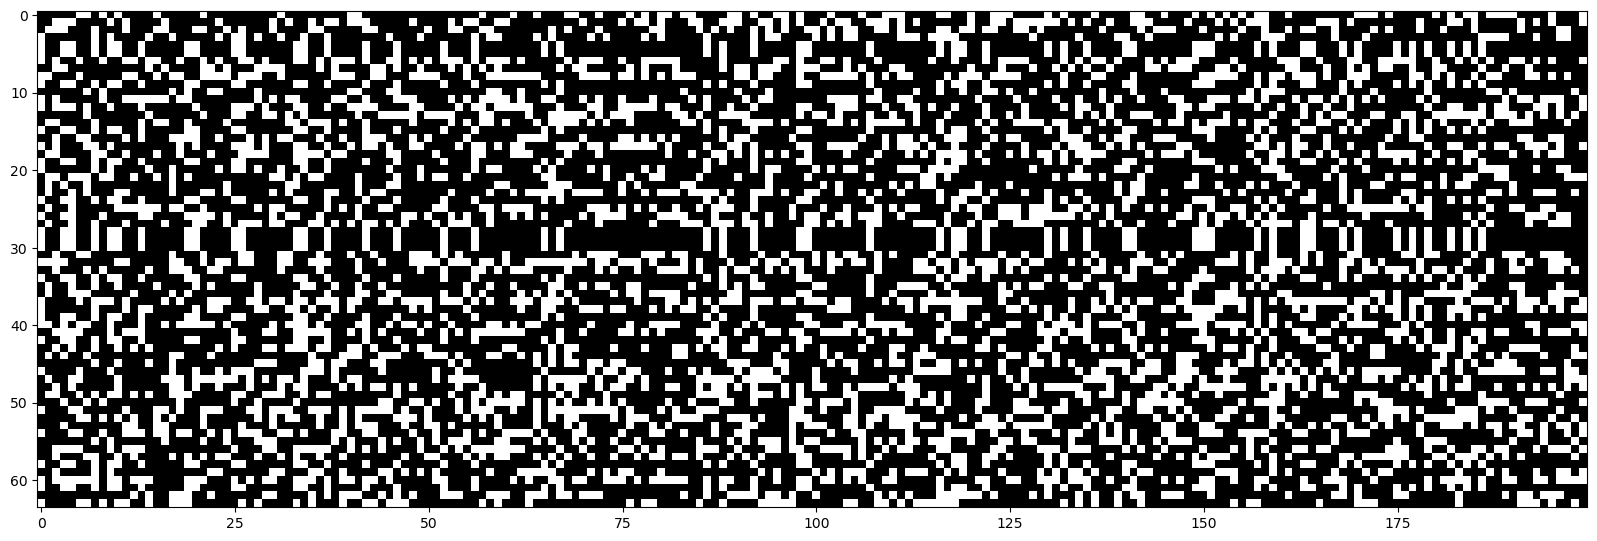

In [67]:
# Let us look at the backward propagation through tanh

# From the micrograd library, we can see that the backward propagation through tanh is as follows:
# def backward(self, grad):
#     self.grad = (1 - t**2) * out.grad()
#     out.backward = backward
#     return out

# So if the gradient passing through tanh is somehow becomes zero, the entire layer will just take the 
# out.grad() it received and send it to the next neuron as t is equal to zero.
# This means the neuron will saturate and it won't learn anything, because its gradient is zero.
plt.figure(figsize=(20,10))
plt.imshow(hpreact.abs()>0.99,cmap='gray',interpolation='nearest')
#plt.imshow(hpnonbatchnorm.abs()>0.99,cmap='gray',interpolation='nearest')

# The above plotting shows the activations h (high values of h.abs()) before its activation using the tanh function.
# it is not good to have all whites, as very high activations means that the tanh can likely be in a region where
# the gradient is flat. As less excited as the neuron is, it is better. Therefore, hpreact is a much better matrix.
# It has more black pixels, which means that the activations are not as high, so therefore, less chance to saturate
# during training.


tensor(0.0074) tensor(0.9938)
tensor(-0.0030) tensor(3.1726)
tensor(-0.0034) tensor(5.2876)


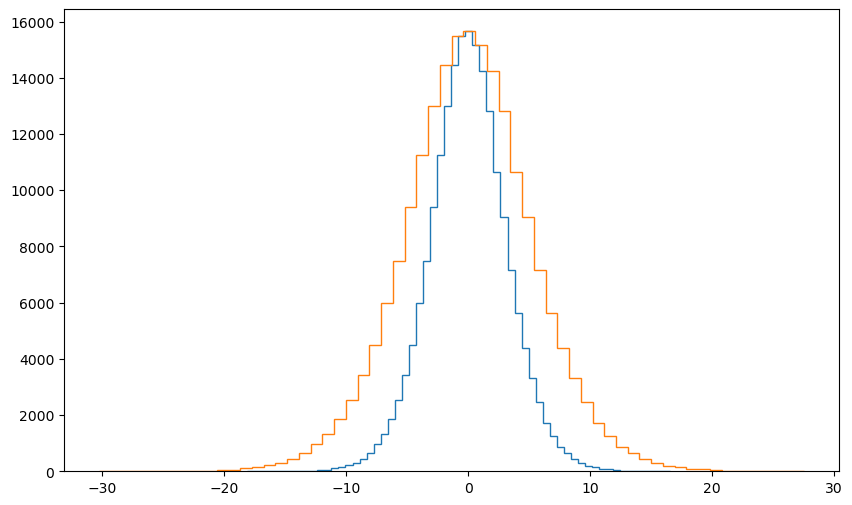

In [68]:
# The above problem can be dealt by batchnorm, which is a normalization of the activations of each layer.
# You can try doing that simply by postmultiplying the hpreact matrix by a value that reduces the mean 
# and standard deviation of the matrix.
# exampoe
x = torch.randn(1000,10)
W = torch.randn(10,200)
y = x@W
gain = 5/3
bias = 0
z = gain* (y - y.mean() / y.std()) + bias
print(x.mean(),x.std())
print(y.mean(),y.std())
print(z.mean(),z.std())
plt.figure(figsize=(10,6))
#plt.subplot(131)
#plt.hist(x.view(-1).tolist(),60,histtype='step');
#plt.subplot(132)
plt.hist((y.view(-1)),60,histtype='step');
#plt.subplot(133)
plt.hist(z.view(-1),60,histtype='step');

# The above shows that if a gaussian distribution is passed through a neuron with weights W,
# the resulting distribution becomes 'squashed'

# A batchnorm layer removes the input layers mean, divides it by standard deviation of 1, and is a further linear layer to this
# expression which act as gain (weight of the linear layer) and bias (bias of the linear layer), to boost the mean and standard deviation
# of the output of the batchnorm layer to something the network finds useful to transfer the gradients across the layer reliably (no saturated neurons).


In [51]:
# Now let us PYTORCHIFY our code.
# Make the code look more like pytorch's implementations.

class Linear:

    def __init__(self, fan_in, fan_out, bias=True): # initializing the layer
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # (fan_in**0.5 ) conditions the matrix for initialization
        self.bias = torch.zeros(fan_out) if bias else None # if the bias is true. Normaly, if it the linear layer is followed by a tanh, switch this to false due to reasons previously described.
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias # use bias if set to True
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) # return the outputs when Linear.parameters() is called

# Test:
# Linear(10,200,bias=False).parameters()

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # set the epsilon to 1e-8 to prevent division by zero
        self.momentum = momentum # set the momentum to 0.1
        self.training = True # set the training to True. Because when initialized, it should likely be for training purposes.
        # set the gain and bias of the batchnorm layer to 1 and 0 respectively on initialization.
        self.gamma = torch.ones(dim) # set the gamma to 1
        self.beta = torch.zeros(dim) # set the beta to 0
        # set the running mean and running variance to 0 and 1 respectively on initialization. This will be used for tracking during training.
        self.running_mean = torch.zeros(dim) # set the running mean to 0
        self.running_var = torch.ones(dim) # set the running variance to 1
    
    def __call__(self,x): # what happens when an input is given to the BatchNorm1d layer.
        # forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True) # calculate the mean of the input x
            xvar = x.var(0,keepdim=True) # calculate the variance of the input x
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # calculate the normalized input x
        self.out = self.gamma * xhat + self.beta # calculate the output of the batchnorm layer using its gain and bias, i.e., gamma and beta
        # when calling without training on, update the running meand and standard deviation of the batchnorm layer.
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# Test:
# BatchNorm1d(200).parameters()

class Tanh:

    def __call__(self,x): # no init for Tanh class because it is a simple activation operation
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return [] # no parameters in the activation function

# Test:
# plt.hist(Tanh()(Linear(10,200,bias=True).parameters()[0]).tolist())

# Now begin building the network:
# Some hyper parameters
n_embeddings = 10 # number of embeddings in the first layer
block_size = 3
n_hidden = 100 # number of neurons in the hidden layer 
g = torch.Generator().manual_seed(42) # set the seed to 42
vocab_size = 27 # number of unique characters in the dataset
# Construct the layers
C = torch.randn((vocab_size,n_embeddings),generator=g) # work embedding matrix for each block

# without batch normalization
#layers = [
#    Linear(n_embeddings*block_size,n_hidden), Tanh(),#Tanh(), # first layer converts word embeddings from C to hidden layer 1 through a Tanh operation
#    Linear(             n_hidden,n_hidden), Tanh(),#Tanh(), # hidden layers continue
#    Linear(             n_hidden,n_hidden), Tanh(),#Tanh(), # ---
#    Linear(             n_hidden,n_hidden), Tanh(),#Tanh(), # ---
#    Linear(             n_hidden,n_hidden), Tanh(),#Tanh(), # ---
#    Linear(             n_hidden,vocab_size), # output neuron to the vocab size which can be referenced to the softmax for classification of next character
#] # hidden layers followed by an output layer scaled down to the vocab size

# with batch normalization, also turn off the bias in the linear layers preceeding a tanh activation layer
layers = [
    Linear(n_embeddings*block_size,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),#Tanh(), # first layer converts word embeddings from C to hidden layer 1 through a Tanh operation
    Linear(               n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),#Tanh(), # hidden layers continue
    Linear(               n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),#Tanh(), # ---
    Linear(               n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),#Tanh(), # ---
    Linear(               n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),#Tanh(), # ---
    Linear(               n_hidden,vocab_size,bias=False), BatchNorm1d(vocab_size),# output neuron to the vocab size which can be referenced to the softmax for classification of next character
]

# initialization considerations
with torch.no_grad():
    # make the last layer less confident to avoid first iteration error to be very high
    #layers[-1].weight *= 0.1 # this is not conditioned to 5/3 as it is an output neuron. all others, being followed by a tanh, are conditioned to 5/3
    layers[-1].gamma *= 0.1 # if last layer is batchnorm, then the gamma should be conditioned to 0.1 as well
    # apply a small gain to all others to boost their means:
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1.0 # 5/3 is the gain of tanh. Empirically the best for initialization
            #layer.weight *= 1 # 5/3 is the gain of tanh # this is for testing purposes to see how the activations are distributed before the tanh layer in the linear layer
            #layer.weight *= 5 # 5/3 is the gain of tanh # this is for testing purposes to see how the activations are distributed before the tanh layer in the linear layer
            #layer.weight *= 1 # use for the case when all tanh layers are removed. The correct boost should be 1, as there is no activation function following the linear layer.
            #layer.weight *= 1.0 # use for case where batchnorm operations are added in the layer before the activation function
# Collect parameters, see how many there are and switch their requires_grad to True for autograd operations
parameters = [C] + [p for layer in layers for p in layer.parameters()] # parameters of the network
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True # set the requires_grad to True for all parameters


47551


In [40]:
# optimization
niters = 10000
batch_size = 32
lossi = []
ud = [] # update to data ratio
for i in range(niters):

    # mini batching
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) # returns 32 randomized instances if integers between 0 and the training set size
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    # Linear layer
    emb = C[Xb] # get word embeddings from C
    x = emb.view(emb.shape[0], -1) # reshape it 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # indexes inserted into grount truths in Y
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # retain the gradient of the output of the layer
    for p in parameters:
        p.grad = None # set the gradient to zero before each iteration to prevent accumulation
    loss.backward() # autograd used here to update the gradients of the parameters
    
    # set learning rate decay schedule
    # the idea in the above is to start with a small number and iterate to converge faster towards the end
    if i< 100000: # implement a small decay in the later stages to change our learning rate to something slower for better convergence as we see that with 0.1 it starts to plateau quickly
        lr = 1.0
    else:
        lr = 0.01

    # calculate loss
    for p in parameters:
        p.data += -lr*p.grad # update paramerters based on iteration based learning rate
    
    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{niters:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters]) # update to data ratio
        # first part of the expression, excluding log, shows how great is the update applied to the network between iterations.
    
    #break # for now, break at first loop to inspect the loss for the plots in the next segment
    


      0/  10000: 3.3158
   1000/  10000: 2.7667
   2000/  10000: 2.6263
   3000/  10000: 2.3189
   4000/  10000: 1.9844
   5000/  10000: 2.2867
   6000/  10000: 2.0746
   7000/  10000: 2.4023
   8000/  10000: 2.7271
   9000/  10000: 2.1388


layer 2 {      Tanh}: mean -0.02, std:0.74, saturated: 18.66%
layer 5 {      Tanh}: mean -0.01, std:0.75, saturated: 15.38%
layer 8 {      Tanh}: mean -0.02, std:0.73, saturated: 10.22%
layer 11 {      Tanh}: mean -0.01, std:0.73, saturated: 7.22%
layer 14 {      Tanh}: mean +0.01, std:0.75, saturated: 11.12%
grad of layer 2 {      Tanh}: mean -0.00, std:0.00
grad of layer 5 {      Tanh}: mean +0.00, std:0.00
grad of layer 8 {      Tanh}: mean -0.00, std:0.00
grad of layer 11 {      Tanh}: mean -0.00, std:0.00
grad of layer 14 {      Tanh}: mean -0.00, std:0.00


Text(0.5, 1.0, 'gradient histograms')

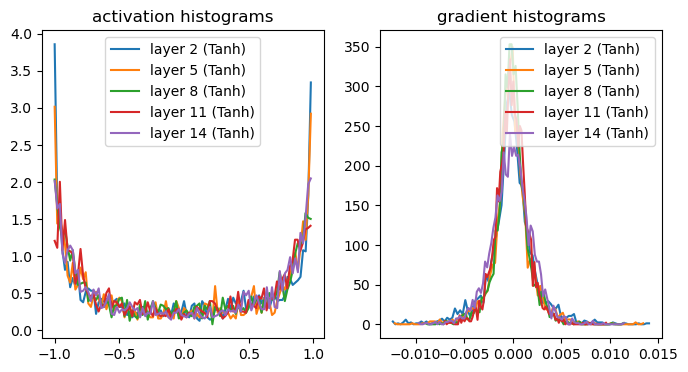

In [41]:
# Now investigate what happens to the parameters in the first iteration
# This is a figure you can tweak to see what happend when the activation layers are not initialized with a previous linear layer boosted by a gain of 5/3 when constructing the network.
plt.figure(figsize=(8,4))
legends = []
plt.subplot(121)
for i,layer in enumerate(layers[:-1]): # loop over layers, with a counter i and a separate variable layer
    if isinstance(layer,Tanh): # only plot the activation function for inspecting the properties of this layer
    #if isinstance(layer,Linear): # only plot for the case when all Tanhs are removed from the network
        t = layer.out
        print('layer %d {%10s}: mean %+.2f, std:%.2f, saturated: %.2f%%' % (i,layer.__class__.__name__,t.mean(),t.std(),100*(t.abs()>0.97).float().mean()))
        hy, hx = torch.histogram(t,density=True,bins=100) # get the histogram of the output of the layer
        plt.plot(hx[:-1].detach(),hy.detach(),label='layer %d' % i) # plot the histogram
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation histograms')
# if all of the tanhs are removed from the network, the above plot will collapse to a gaussian, which is the correct state when tanh is not involved.

# Do a similar thing, but for the gradients of the tanh layers
plt.subplot(122)
#plt.figure(figsize=(4,2))
legends = []
for i,layer in enumerate(layers[:-1]): # loop over layers, with a counter i and a separate variable layer
    if isinstance(layer,Tanh): # only plot the activation function for inspecting the properties of this layer
    #if isinstance(layer,Linear): # only plot for the case when all Tanhs are removed from the network
        t = layer.out.grad
        print('grad of layer %d {%10s}: mean %+.2f, std:%.2f' % (i,layer.__class__.__name__,t.mean(),t.std()))
        hy, hx = torch.histogram(t,density=True,bins=100) # get the histogram of the output of the layer
        plt.plot(hx[:-1].detach(),hy.detach(),label='layer %d' % i) # plot the histogram
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient histograms')

weight   (27, 10): mean -0.00, std:0.01, grad: data ratio 6.628831e-03
weight  (30, 100): mean -0.00, std:0.01, grad: data ratio 1.084003e-02
weight (100, 100): mean +0.00, std:0.00, grad: data ratio 1.076756e-02
weight (100, 100): mean +0.00, std:0.00, grad: data ratio 1.038607e-02
weight (100, 100): mean -0.00, std:0.00, grad: data ratio 9.099147e-03
weight (100, 100): mean -0.00, std:0.00, grad: data ratio 8.585930e-03
weight  (100, 27): mean -0.00, std:0.00, grad: data ratio 8.324705e-03


Text(0.5, 1.0, 'weight gradient distribution of the linear layers')

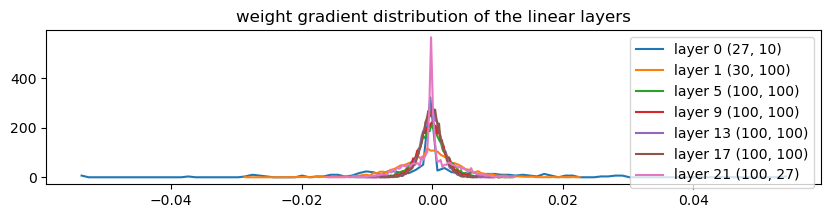

In [42]:
# Another investigation before training is the visualization of the change in the parameters
plt.figure(figsize=(10,2))
legends = []
for i,p in enumerate(parameters):
    t = p.grad # gradient in parameters
    if p.ndim==2:   # only plot the parameters of the weights linear layers, not biases or the batchnorm layers, you can look for those as well if you like to
        print('weight %10s: mean %+.2f, std:%.2f, grad: data ratio %e' % (tuple(p.shape),t.mean(),t.std(),t.abs().mean()/p.abs().mean()))
        hy, hx = torch.histogram(t,density=True) # get the histogram of the output of the layer
        plt.plot(hx[:-1].detach(),hy.detach()) # plot the histogram
        legends.append(f'layer {i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weight gradient distribution of the linear layers')

# The plot shows that the standard deviation of the last layer is similar to the others when training has been completed.
# if you train for very few iterations, grad data ratio for the last layer will be very high. The reason for this is that
# the last layer is very strongly influenced in the first few iterations by the gradient of the loss function.


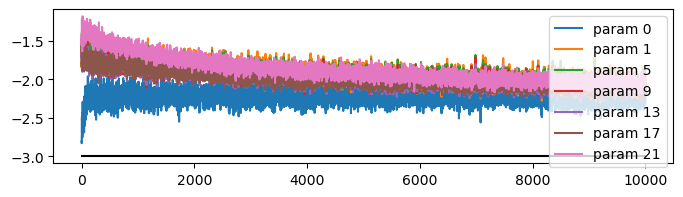

In [44]:
# visualize ud, the change in parameters over iterations. Karpathy suggests a typical value of -3 is good, because 
# if it is lower, than the neurons are changing by a very small value, and this means the learning rate must be too low.
plt.figure(figsize=(8,2))
legends =  []
for i,p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)
plt.plot([0, len(ud)],[-3, -3],'k')
plt.legend(legends);

# Despite batchnorm, this function will still be affected if the choice to boost the gain of the 
# linear layers preceeding activation layers is not done by exactly 5/3.
# some tweaking of the initial gain and the learning rate is needed to get the ud to be around -3 for all layers for 
# the network to behave well during training.


In [45]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 19.30600357055664
val 19.335899353027344


In [49]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
nin.
